In [287]:
# !pip3 install astropy
# !pip3 install sunpy
# !pip3 install numba
# !pip3 install lxml
# !pip3 install zeep
# !pip3 install drms
# !pip3 install h5netcdf
# !pip3 install cdflib
# !pip3 install netCDF4
# ! pip3 install spacepy
# ! pip3 install dtaidistance

In [390]:

%matplotlib inline
import numba
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from astropy import units as u
from astropy.time import Time
import astropy
import sunpy
from sunpy.coordinates import frames
import matplotlib.dates as mdates
import nice_plots as nplt
nplt.nice_plots(fs=20)
import pandas as pd
from scipy.signal import find_peaks
import glob
import os
from sunpy.net import Fido, attrs
import pandas as pd
from sunpy.timeseries import TimeSeries
import netCDF4 as nc
from astropy.constants import k_B, m_p
from spacepy import pycdf
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from dtaidistance import dtw

In [411]:
#CR Map details 

# cr = 2288
# start_cr = 2288.2953724
# end_cr = 2289.294

cr = 2289
start_cr = 2288.9459
end_cr = 2290.0

# cr = 2290
# start_cr = 2289.95501
# end_cr = 2291.036563

t_start = sunpy.coordinates.sun.carrington_rotation_time(start_cr)
t_end = sunpy.coordinates.sun.carrington_rotation_time(end_cr)
t_cr_start = datetime.strptime(str(t_start), '%Y-%m-%d %H:%M:%S.%f')

dt = t_end - t_start
n_hr = dt.value * 24
# print(":::CR"+str(cr)+" details:::")
print("\nStarting time: ", t_start)
print("Ending time: ", t_end)

D0 = np.loadtxt(f'{cr}/Cone_model_{cr}/{cr}_EARTH_WCME.dat')
# D1 = np.loadtxt('2288_analysis_SW_5.dat')
D2 = np.loadtxt(f'{cr}_periodic/Fri3D_{cr}/{cr}_analysis.dat')
Obs_d = np.loadtxt(f'./{cr}/omni2_data.dat',skiprows=1)
output_directory = f"./{cr}_periodic/"
file_pattern_swis = os.path.join(f'./{cr}/SWIS_{cr}', 'AL1_ASW91_L2_BLK_2024*_UNP_9999_999999_V01.cdf')
file_pattern_mag = os.path.join(f'./{cr}/Mag_{cr}', 'L2_AL1_MAG_2024*_V00.nc')


Starting time:  2024-09-18 02:52:02.428
Ending time:  2024-10-16 21:04:09.641


In [412]:
date1 = "2024-09-18 02:52:02"  
date2 = "2024-10-03 23:43:00" 

format = "%Y-%m-%d %H:%M:%S"
datetime1 = datetime.strptime(date1, format)
datetime2 = datetime.strptime(date2, format)

time_difference = datetime2 - datetime1
seconds_difference = time_difference.total_seconds()

print(f"The difference in seconds is: {seconds_difference}")

The difference in seconds is: 1371058.0


In [413]:
def window(date, dataq, window_size):
    kq = np.zeros(len(datetime_list))
    for i in range(len(datetime_list)):
        k=[]
        for j in range(len(date)):
            if (abs((datetime_list[i] - date[j]).total_seconds()) <= window_size*60.0/2):
                k.append(dataq[j])
        if len(k)!=0:
            kq[i] = np.nanmean(np.array(k))
        else:
            kq[i] = np.nan
    return kq

@jit(nopython=True)
def window2(date_timestamps, dataq, datetime_timestamps, window_size):
    kq = np.zeros(len(datetime_timestamps))
    
    for i in range(len(datetime_timestamps)):
        k = []
        for j in range(len(date_timestamps)):
            if abs(datetime_timestamps[i] - date_timestamps[j]) <= window_size * 60.0 / 2:
                k.append(dataq[j])
        if len(k) != 0:
            kq[i] = np.nanmean(np.array(k))
        else:
            kq[i] = np.nan
    
    return kq

# def window(date, data, window_size):

#     window_size_seconds = window_size * 60.0
#     results = np.full(len(date), np.nan)

#     datetime_seconds = np.array([dt.timestamp() for dt in date])
#     date_seconds = np.array([dt.timestamp() for dt in date])

#     for i, d in enumerate(date_seconds):
#         within_window = np.abs(datetime_seconds - d) <= window_size_seconds / 2
#         if np.any(within_window):
#             results[i] = np.nanmean(data[within_window])

#     return results

# print(np.shape(speed_simulation_0))
# print(np.shape(date_simul_0))

windowsize = 60 #in minutes

In [414]:
#Plot obs data

# Obs_d = data
Obs_d.shape

def convert_to_datetime(year, doy, hour):
    start_date = datetime(year, 1, 1)
    
    target_date = start_date + timedelta(days=doy - 1)
    
    target_date = target_date.replace(hour=hour)
    
    return target_date


dates = []
obs_b = []
obs_v = []
obs_rho = []
obs_temp = []
for i in range(len(Obs_d[:,0])):
    if Obs_d[i,5] != 99999.9 :
        dt = convert_to_datetime(int(Obs_d[i,0]), int(Obs_d[i,1]), int(Obs_d[i,2]))
        dates.append(dt)
        obs_b.append(Obs_d[i,3])
        obs_v.append(Obs_d[i,6])
        obs_rho.append(Obs_d[i,5])
        obs_temp.append(Obs_d[i,4])
        
date_arr = np.array(dates)
obs_b_array = np.array(obs_b)
mask_b = (obs_b_array != 9999.99) & (obs_b_array != 999.9)


obs_rho_array = np.array(obs_rho)
mask_rho = (obs_rho_array != 999.99)

obs_t_array = np.array(obs_temp)
mask_t = (obs_t_array != 9999999.)

# print(dates)

In [415]:
# start_date_swis = datetime(2024, 8, 31) #2288
start_date_swis = datetime(2024, 9, 18) #2289
# start_date_swis = datetime(2024, 10, 15) #2290

time_combined = []
V_combined = []
n_combined = []
thermal_combined = []

for file_name in sorted(glob.glob(file_pattern_swis)):
    
    data = pycdf.CDF(file_name)
    epoch = data['epoch_for_cdf'][:]
#     print(data.keys())
    proton_density = data['proton_density'][:]
    proton_density[proton_density ==-1e+31] = np.nan
    
    proton_bulk = data['proton_bulk'][:]
    proton_bulk[proton_bulk ==-1e+31] = np.nan
    
    proton_thermal = data['proton_thermal'][:]
    proton_thermal[proton_thermal ==-1e+31] = np.nan
    
    epoch_timestamps = np.array([e.timestamp() for e in epoch])
    epoch_seconds = epoch_timestamps - start_date_swis.timestamp()
    time_combined.extend(epoch_seconds)
    V_combined.extend(proton_bulk)
    n_combined.extend(proton_density)
    thermal_combined.extend(proton_thermal)

    data.close()

time_combined = np.array(time_combined)
V_combined = np.array(V_combined)
n_combined = np.array(n_combined)
thermal_combined = np.array(thermal_combined)

data_to_save = np.column_stack([time_combined, V_combined, n_combined, thermal_combined])

output_file = os.path.join(output_directory, f"processed_V_N_T_data.txt")
header = "Epoch (s since start_date)\tBulk\tdensity\tThermal velocity"
if not os.path.exists(output_file):
    np.savetxt(output_file, data_to_save, header=header, delimiter="\t", fmt="%.6e")
else:
    with open(output_file, 'ab') as f:
        np.savetxt(f, data_to_save, delimiter="\t", fmt="%.6e")

        
epoch_start = datetime(1970, 1, 1, 0, 0, 0)
time_combined = []
bx_gse_combined = []
by_gse_combined = []
bz_gse_combined = []
time_to_save = []
for file_name in sorted(glob.glob(file_pattern_mag)):
    data = nc.Dataset(file_name, 'r')

    time = data.variables['time'][:] 
    bx_gse = data.variables['Bx_gse'][:] 
    by_gse = data.variables['By_gse'][:]  
    bz_gse = data.variables['Bz_gse'][:]
    
    bx_gse = np.where(bx_gse<-1000,np.nan,bx_gse)
    by_gse = np.where(by_gse<-1000,np.nan,by_gse)
    bz_gse = np.where(bz_gse<-1000,np.nan,bz_gse)
    
    time_converted = [epoch_start + timedelta(seconds=int(t)) for t in time]
    time_combined.extend(time_converted)

    bx_gse_combined.extend(bx_gse)
    by_gse_combined.extend(by_gse)
    bz_gse_combined.extend(bz_gse)
    time_to_save.extend(time)
    data.close()

time_combined = np.array(time_combined)
bx_gse_combined = np.array(bx_gse_combined)
by_gse_combined = np.array(by_gse_combined)
bz_gse_combined = np.array(bz_gse_combined)
time_to_save = np.array(time_to_save)

data_to_save = np.column_stack([time_to_save, bx_gse_combined, by_gse_combined, bz_gse_combined])
output_file = os.path.join(output_directory, "processed_Bx_By_Bz_data.txt")
header = "Epoch (s since epoch start_date)\tBx_GSE\tBy_GSE\tBz_GSE"
if not os.path.exists(output_file):
    np.savetxt(output_file, data_to_save, header=header, delimiter="\t", fmt="%.6e")
else:
    with open(output_file, 'ab') as f:
        np.savetxt(f, data_to_save, delimiter="\t", fmt="%.6e")


In [416]:
Obs_Aditya_swis = np.loadtxt(os.path.join(output_directory, f"processed_V_N_T_data.txt"),skiprows=1)
Obs_Aditya_swis_v =[]
Obs_Aditya_swis_rho = []
Obs_Aditya_swis_date = []
Obs_Aditya_swis_TV =[]

for i in range(len(Obs_Aditya_swis)):
    Obs_Aditya_swis_date_ = Obs_Aditya_swis[i,0]
    converted_datetime = start_date_swis + timedelta(seconds=Obs_Aditya_swis_date_)
    Obs_Aditya_swis_date.append(converted_datetime)
    Obs_Aditya_swis_v.append(Obs_Aditya_swis[i,1])
    Obs_Aditya_swis_rho.append(Obs_Aditya_swis[i,2])
    Obs_Aditya_swis_TV.append(Obs_Aditya_swis[i,3])
    
Obs_Aditya_swis_v_array = np.array(Obs_Aditya_swis_v)
Obs_Aditya_swis_rho_array = np.array(Obs_Aditya_swis_rho)
Obs_Aditya_swis_date_array = np.array(Obs_Aditya_swis_date)
Obs_Aditya_swis_TV_array = np.array(Obs_Aditya_swis_TV)

thermal_combined_m_s = Obs_Aditya_swis_TV_array * 1e3  
Obs_Aditya_swis_T_array = (m_p * thermal_combined_m_s**2) / (3 * k_B) 


mag_load_data = np.loadtxt(os.path.join(output_directory, "processed_Bx_By_Bz_data.txt"),skiprows=1)

mag_load_time = mag_load_data[:, 0]
mag_load_bx_gse = mag_load_data[:, 1]
mag_load_by_gse = mag_load_data[:, 2]
mag_load_bz_gse = mag_load_data[:, 3]

In [417]:

# CR_time_period = 2352590  #2288
# CR_time_period = 4091225.0
CR_time_period = 2484692.0  #2289
# CR_time_period = 2551102.0  #2290

ut = 1.496e+13/2.500e+07
print(ut)
Tp_code = CR_time_period/(ut)
print(Tp_code)
t0_code = D0[:,0] - Tp_code
t0_dt = []

def get_datetime_from_elapsed_seconds(start_date, elapsed_seconds):
    result_date = start_date + timedelta(seconds=elapsed_seconds)
    return result_date

start_date = t_cr_start 
for i in range(len(t0_code)):
    el_sec = t0_code[i]*ut 
    result = get_datetime_from_elapsed_seconds(start_date, el_sec)
    t0_dt.append(result)

598400.0
4.152225935828877


In [418]:
vr_indx = 1
rho_indx = 8
prs_indx = 7
Br_indx = 4
Bth_indx = 5
Bph_indx = 6
    
uvel = 250.0 # km/s
urho = 10.0 # particles /cc
uT = 7.517e+06/1.0e6 # MK
umag = 3.624e-04*1.0e5 #nT

Temp0 = (D0[:,prs_indx]/D0[:,rho_indx])*uT
# Temp1 = (D1[:,prs_indx]/D1[:,rho_indx])*uT
Temp2 = (D2[:,prs_indx]/D2[:,rho_indx])*uT

Bmag0 =  umag*np.sqrt(D0[:,Br_indx]**2 + D0[:,Bth_indx]**2 + D0[:,Bph_indx]**2)
# Bmag1 =  umag*np.sqrt(D1[:,Br_indx]**2 + D1[:,Bth_indx]**2 + D1[:,Bph_indx]**2)
Bmag2 =  umag*np.sqrt(D2[:,Br_indx]**2 + D2[:,Bth_indx]**2 + D2[:,Bph_indx]**2)

## Moving Average

In [419]:
# start_time = datetime(2024, 9, 1, 0, 0, 0)  #2288
# end_time = datetime(2024, 9, 27, 0, 0, 0)  #2288

start_time = datetime(2024, 9, 15, 0, 0, 0)  #2289
end_time = datetime(2024, 10, 13, 22, 0, 0)  #2289

# start_time = datetime(2024, 10, 15, 0, 0, 0)  #2290
# end_time = datetime(2024, 11, 13, 23, 0, 0)  #2290

print("Start ", start_time)
print("End  ", end_time)

datetime_list = []
current_time = start_time

while current_time <= end_time:
    datetime_list.append(current_time)
    current_time += timedelta(minutes=5)

datetime_list_epoch_timestamps = np.array([e.timestamp() for e in datetime_list])
datetime_list_epoch_seconds = datetime_list_epoch_timestamps - start_date_swis.timestamp()

Start  2024-09-15 00:00:00
End   2024-10-13 22:00:00


In [420]:
epoch_timestamps = np.array([e.timestamp() for e in Obs_Aditya_swis_date_array])
epoch_seconds = epoch_timestamps - start_date_swis.timestamp()

moving_average_speed_Aditya_swis = window2(epoch_seconds, Obs_Aditya_swis_v_array,datetime_list_epoch_seconds,  windowsize)
moving_average_speed_0 = window(t0_dt, D0[:,vr_indx]*uvel, windowsize)
# moving_average_speed_1 = window(t0_dt[:6444], D1[:6444,vr_indx]*uvel, windowsize)
moving_average_speed_2 = window(t0_dt, D2[:,vr_indx]*uvel, windowsize)
moving_average_speed_Obs = window(dates, obs_v,  windowsize)

moving_average_density_Obs = window(np.array(dates)[mask_rho], np.array(obs_rho)[mask_rho], windowsize) 
moving_average_density_0 = window(t0_dt, D0[:,rho_indx]*urho, windowsize) 
# moving_average_density_1 = window(t0_dt[:6444], D1[:6444,rho_indx]*urho, windowsize)
moving_average_density_2 = window(t0_dt, D2[:,rho_indx]*urho, windowsize)
moving_average_density_Aditya_swis = window2(epoch_seconds, Obs_Aditya_swis_rho_array,datetime_list_epoch_seconds,  windowsize)

In [421]:
time_combined =  [epoch_start + timedelta(seconds=int(t)) for t in mag_load_time]
time_combined_timestamps = np.array([t.timestamp() for t in time_combined])- start_date_swis.timestamp()

moving_average_combined_Bx = window2(time_combined_timestamps, mag_load_bx_gse, datetime_list_epoch_seconds, windowsize)  
moving_average_combined_By = window2(time_combined_timestamps, mag_load_by_gse, datetime_list_epoch_seconds, windowsize)
moving_average_combined_Bz = window2(time_combined_timestamps, mag_load_bz_gse, datetime_list_epoch_seconds, windowsize)
B_AL1_mag = (np.sqrt(moving_average_combined_Bz**2 + 
                     moving_average_combined_By**2 + moving_average_combined_Bx**2))

moving_average_temp_Obs = window(np.array(dates)[mask_t], np.array(obs_temp)[mask_t], windowsize) 
moving_average_temp_0 = window(t0_dt, Temp0, windowsize) 
# moving_average_temp_1 = window(t0_dt[:6444], Temp1[:6444], windowsize)
moving_average_temp_2 = window(t0_dt, Temp2, windowsize)  
moving_average_temp_Aditya_swis = window2(epoch_seconds, Obs_Aditya_swis_T_array, datetime_list_epoch_seconds,  windowsize)

moving_average_Mag_Obs = window(np.array(dates)[mask_b], np.array(obs_b)[mask_b], windowsize) 
moving_average_Mag_0 = window(t0_dt, Bmag0, windowsize) 
# moving_average_Mag_1 = window(t0_dt[:6444], Bmag1[:6444], windowsize)
moving_average_Mag_2 = window(t0_dt, Bmag2, windowsize)  


In [422]:
logo_path = "./SWASTi_logo.png" 
logo = mpimg.imread(logo_path)
print(np.shape(moving_average_speed_Aditya_swis))
print(np.shape(moving_average_speed_Obs))
print(np.shape(moving_average_speed_2))

# print(moving_average_speed_Aditya_swis)
# print(moving_average_speed_Obs)

(8329,)
(8329,)
(8329,)


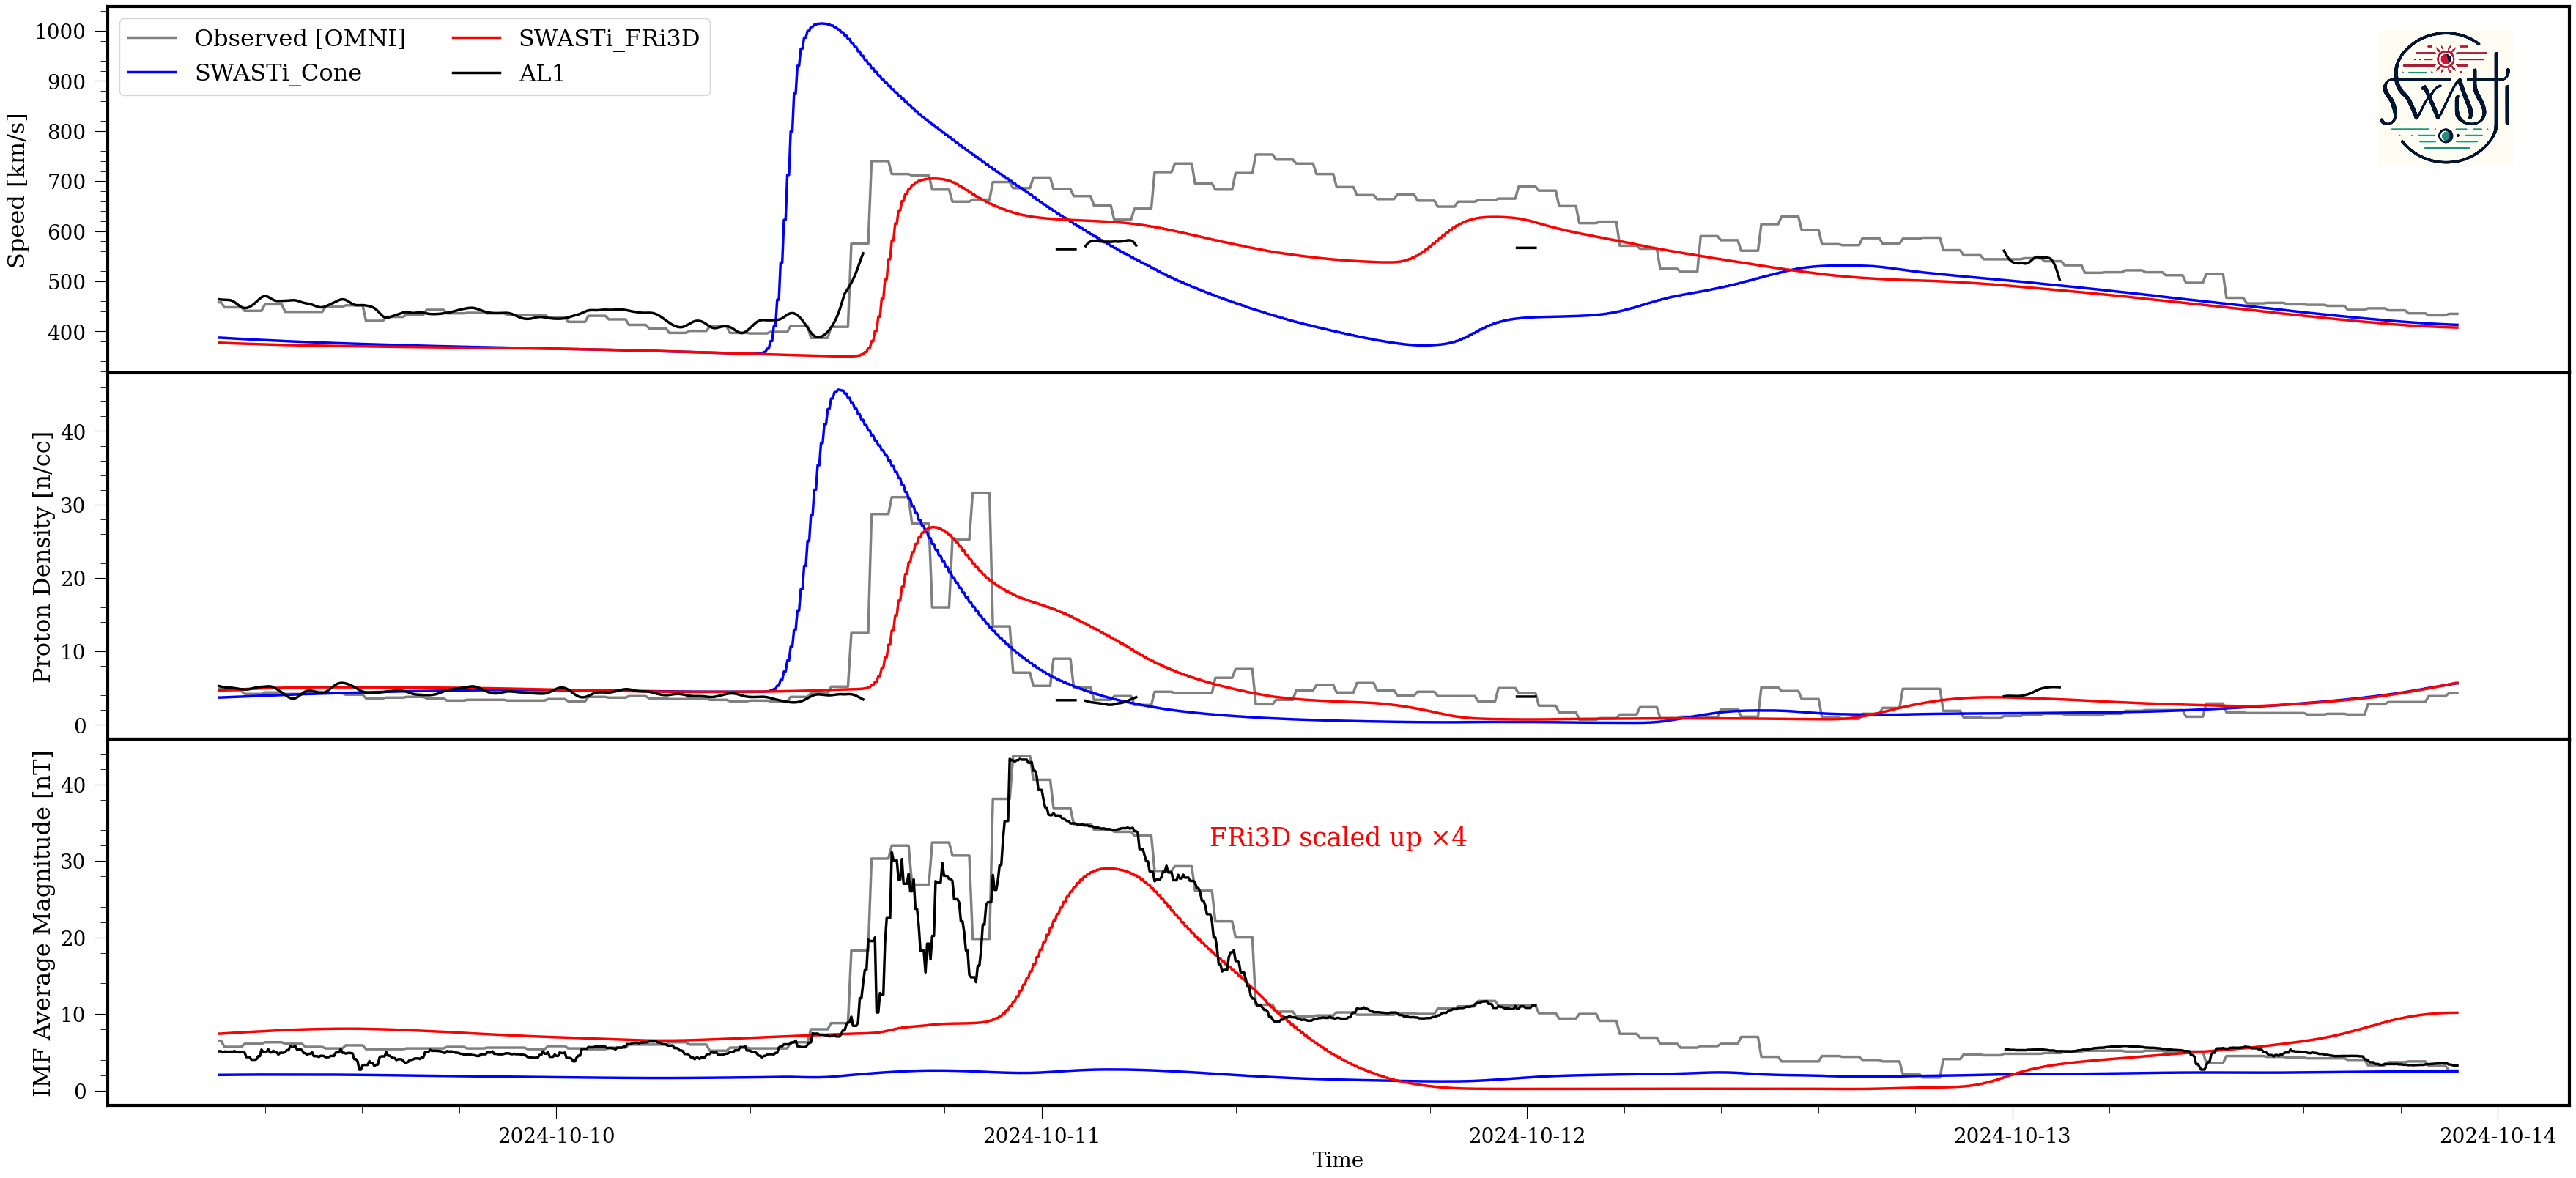

In [429]:
f1 = plt.figure(figsize=[36,19])
plt.subplots_adjust(wspace=1.2)

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

ax1 = f1.add_subplot(411)
plt.plot(datetime_list[7000:], moving_average_speed_Obs[7000:],  label='Observed [OMNI]', color = "gray")
plt.plot(datetime_list[7000:], moving_average_speed_0[7000:], color = 'b', label='SWASTi_Cone',)
# plt.plot(datetime_list[1000:-1000], moving_average_speed_1[1000:-1000], color = 'g', label='SWASTi_FRi3D_high',)
plt.plot(datetime_list[7000:], moving_average_speed_2[7000:], color = 'r', label='SWASTi_FRi3D',)
plt.plot(datetime_list[7000:], moving_average_speed_Aditya_swis[7000:], color = 'k', label='AL1',)
ax1.minorticks_on()
ax1.tick_params(axis='both', labelsize=20)
ax1.set_ylabel('Speed [km/s]', fontsize = 23)

imagebox = OffsetImage(logo, zoom=0.20)  
ab = AnnotationBbox(imagebox, (0.95, 0.75), xycoords='axes fraction', frameon=False)
ax1.add_artist(ab)

ax2 = f1.add_subplot(412, sharex=ax1)
plt.plot(datetime_list[7000:], moving_average_density_Obs[7000:],  label='Observed [OMNI]', color = "gray")
plt.plot(datetime_list[7000:], moving_average_density_0[7000:], color = 'b', label='SWASTi_Cone',)
# plt.plot(datetime_list[1000:-1000], moving_average_density_1[1000:-1000], color = 'g', label='SWASTi_FRi3D_high',)
plt.plot(datetime_list[7000:], moving_average_density_2[7000:], color = 'r', label='SWASTi_FRi3D',)
plt.plot(datetime_list[7000:], moving_average_density_Aditya_swis[7000:], color = 'k', label='AL1',)
ax2.minorticks_on()
ax2.tick_params(axis='both', labelsize=20)
ax2.set_ylabel('Proton Density [n/cc]', fontsize = 23)

# ax3 = f1.add_subplot(413, sharex=ax1)
# plt.plot(datetime_list[5500:], moving_average_temp_Obs[5500:]/1.0e6,  label='Observed [ACE]', color = "gray")
# plt.plot(datetime_list[5500:], moving_average_temp_0[5500:], color = 'b', label='SWASTi_Cone',)
# # plt.plot(datetime_list[1000:-1000], moving_average_temp_1[1000:-1000], color = 'g', label='SWASTi_Fri3D_high',)
# plt.plot(datetime_list[5500:], moving_average_temp_2[5500:], color = 'r', label='SWASTi_Fri3D',)
# plt.plot(datetime_list[5500:], moving_average_temp_Aditya_swis[5500:]/1.0e6, label='AL1', color='k')
# ax3.minorticks_on()
# ax3.tick_params(axis='both', labelsize=20)
# ax3.set_ylabel('Proton Temperature [MK]', fontsize = 23)
# # ax3.set_ylim(0,1)

ax4 = f1.add_subplot(413, sharex=ax1)
plt.plot(datetime_list[7000:], moving_average_Mag_Obs[7000:],  label='Observed [OMNI]', color = "gray")
plt.plot(datetime_list[7000:], moving_average_Mag_0[7000:], color = 'b', label='SWASTi_Cone',)
# plt.plot(datetime_list[1000:-1000], moving_average_Mag_1[1000:-1000], color = 'g', label='SWASTi_Fri3D_high',)
plt.plot(datetime_list[7000:], moving_average_Mag_2[7000:]*4.0, color = 'r', label='SWASTi_Fri3D',)
plt.plot(datetime_list[7000:], B_AL1_mag[7000:], label='AL1', color='k')
ax4.minorticks_on()
ax4.tick_params(axis='both', labelsize=20)
ax4.set_xlabel('Time')
ax4.set_ylabel('IMF Average Magnitude [nT]', fontsize = 23)
# plt.ylim(0,32)
ax4.text(0.50,0.73, "FRi3D scaled up ×4", transform=ax4.transAxes, ha='center', va='center', fontsize=25, color = "r")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

# for ax in [ax1,ax2,ax3,ax4]:
#     xmin = datetime(2024, 10, 21)
#     xmax = datetime(2024, 11, 13)
#     ax.set_xlim(mdates.date2num(xmin), mdates.date2num(xmax))

ax1.legend(loc='upper left',ncol=2,fontsize=23)
plt.subplots_adjust(hspace=0.0) 
plt.savefig(os.path.join(output_directory,f'Sept_2024_{cr}_FR_Cone_cme_ISRO.png'), dpi = 300)
plt.show()

In [249]:
# xxxxx = moving_average_speed_Aditya_swis

In [431]:
moving_average_speed_Aditya_swis = moving_average_speed_Obs

In [311]:
# moving_average_speed_Aditya_swis = xxxxx

In [231]:
def rmse(x,y):
    return ((np.nanmean((x-y)**2))**0.5)

def std_ratio(v_model, v_obs):
      return (abs(np.nanstd(v_obs) - np.nanstd(v_model))/np.nanstd(v_obs))
    


In [432]:
datasets = ["D0", "D2"]

mask_D0 = ~np.isnan(moving_average_speed_Aditya_swis) & ~np.isnan(moving_average_speed_0)
mask_D2 = ~np.isnan(moving_average_speed_Aditya_swis) & ~np.isnan(moving_average_speed_2)

correlation_speed_0 = np.corrcoef(moving_average_speed_Aditya_swis[mask_D0][7000:], moving_average_speed_0[mask_D0][7000:])[0, 1]
RMSE_speed_0 = rmse(moving_average_speed_Aditya_swis[mask_D0][7000:], moving_average_speed_0[mask_D0][7000:])
STD_speed_0 = std_ratio(moving_average_speed_Aditya_swis[mask_D0], moving_average_speed_0[mask_D0])

correlation_speed_2 = np.corrcoef(moving_average_speed_Aditya_swis[mask_D2][7000:], moving_average_speed_2[mask_D2][7000:])[0, 1]
RMSE_speed_2 = rmse(moving_average_speed_Aditya_swis[mask_D2][7000:], moving_average_speed_2[mask_D2][7000:])
STD_speed_2 = std_ratio(moving_average_speed_Aditya_swis[mask_D2], moving_average_speed_2[mask_D2])

correlation_speed_values = [correlation_speed_0, correlation_speed_2]
rmse_speed_values = [RMSE_speed_0, RMSE_speed_2]
std_speed_values = [STD_speed_0, STD_speed_2]

sigma_speed_values = [
    (1 - corr) ** 2 + (rmse / 100) ** 2 + std ** 2
    for corr, rmse, std in zip(correlation_speed_values, rmse_speed_values, std_speed_values)
]

data_speed = {
    "Dataset": datasets,
    "Correlation": correlation_speed_values,
    "RMSE": rmse_speed_values,
    "STD": std_speed_values,
    "Sigma": sigma_speed_values
}

df_speed = pd.DataFrame(data_speed)
print(df_speed)

  Dataset  Correlation       RMSE       STD     Sigma
0      D0     0.957800  48.871859  0.191283  0.277216
1      D2     0.961949  54.518873  0.124940  0.314289


In [208]:
mask_D0_density = ~np.isnan(moving_average_density_Obs) & ~np.isnan(moving_average_density_0)
mask_D2_density = ~np.isnan(moving_average_density_Obs) & ~np.isnan(moving_average_density_2)

correlation_density_0 = np.corrcoef(moving_average_density_Obs[mask_D0_density], moving_average_density_0[mask_D0_density])[0, 1]
RMSE_density_0 = rmse(moving_average_density_Obs[mask_D0_density], moving_average_density_0[mask_D0_density])
STD_density_0 = std_ratio(moving_average_density_Obs[mask_D0_density], moving_average_density_0[mask_D0_density])

correlation_density_2 = np.corrcoef(moving_average_density_Obs[mask_D2_density], moving_average_density_2[mask_D2_density])[0, 1]
RMSE_density_2 = rmse(moving_average_density_Obs[mask_D2_density], moving_average_density_2[mask_D2_density])
STD_density_2 = std_ratio(moving_average_density_Obs[mask_D2_density], moving_average_density_2[mask_D2_density])

correlation_density_values = [correlation_density_0, correlation_density_2]
rmse_density_values = [RMSE_density_0, RMSE_density_2]
std_density_values = [STD_density_0, STD_density_2]

sigma_density_values = [
    (1 - corr) ** 2 + (rmse / 100) ** 2 + std ** 2
    for corr, rmse, std in zip(correlation_density_values, rmse_density_values, std_density_values)
]

data_density = {
    "Dataset": datasets,
    "Correlation": correlation_density_values,
    "RMSE": rmse_density_values,
    "STD": std_density_values,
    "Sigma": sigma_density_values
}

df_density = pd.DataFrame(data_density)
print(df_density)


  Dataset  Correlation      RMSE       STD     Sigma
0      D0     0.433456  5.266381  0.426071  0.505282
1      D2     0.418157  5.130077  0.452735  0.546142


Text(41.0, 0.5, 'Speed [km/s]')

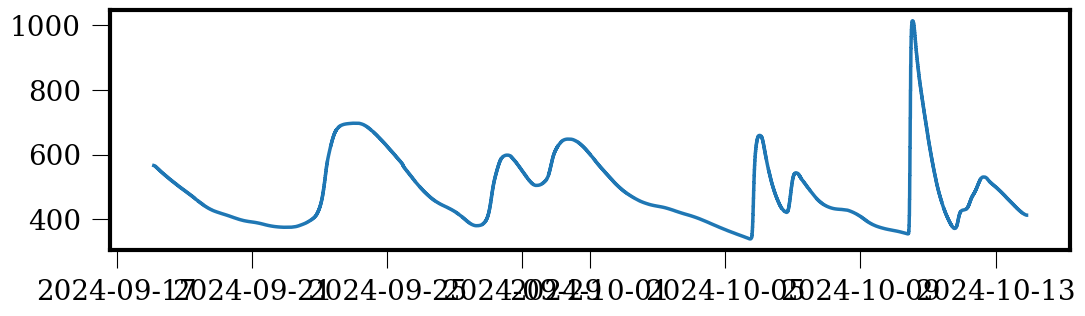

In [263]:
plt.figure(figsize = (12,3))
# plt.plot(datetime_list, moving_average_speed_Obs,  label='Observed [ACE 5min]', color = "gray")
plt.plot(datetime_list, moving_average_speed_0)
ax1.minorticks_on()
ax1.set_ylabel('Speed [km/s]')


In [265]:
arrival_CME_1 = datetime(2024, 10, 10, 14, 46, 0)
date_time_arrival = [arrival_CME_1]

Values of local maxima for 0: [1014.66666667]
Time [datetime.datetime(2024, 10, 10, 13, 5)]


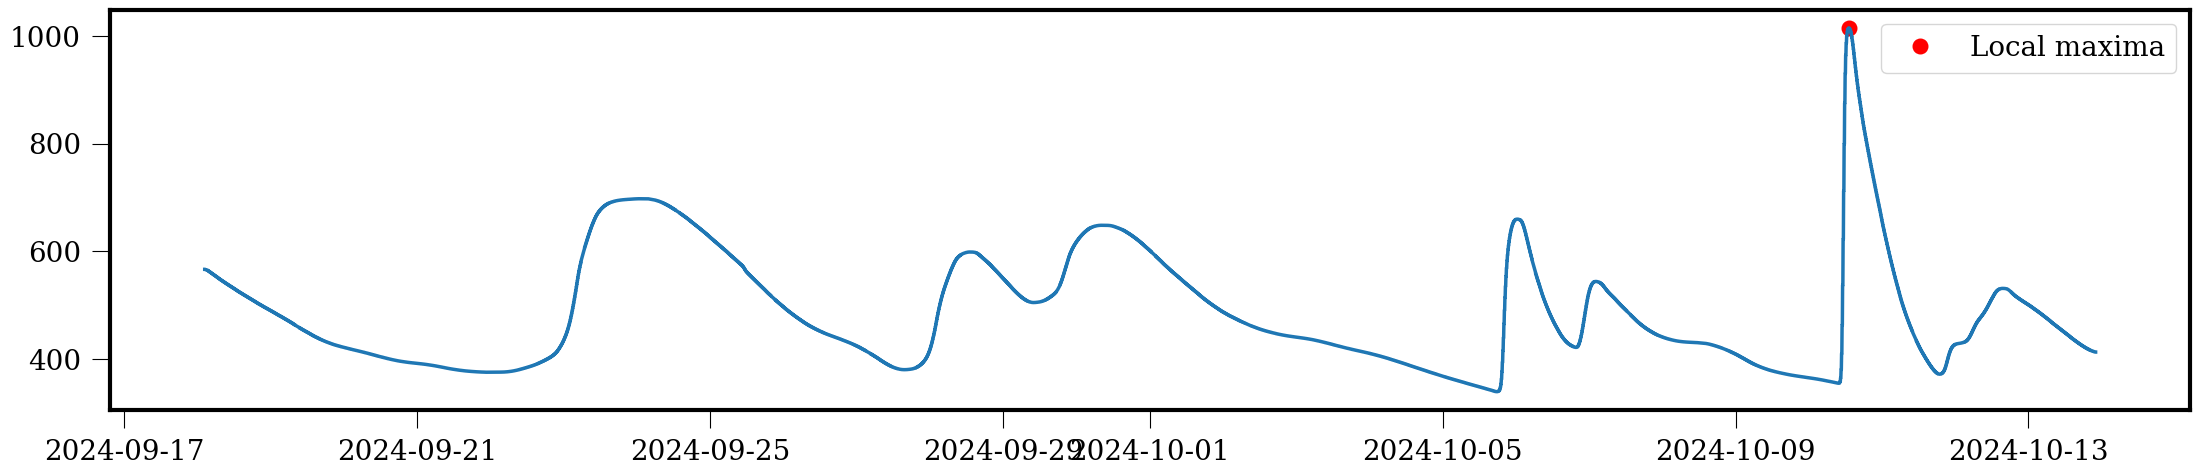

[-1.6833333333333333]


In [280]:
peaks_0, _ = find_peaks(moving_average_speed_0)

delay1 = []

vel_1 = []

for i in [0]:
    locals()[f"peaks_{i}"] = locals()[f"peaks_{i}"][5:-1]
#     print(f"Indices of local maxima for {i}:", locals()[f"peaks_{i}"])
    print(f"Values of local maxima for {i}:", locals()[f"moving_average_speed_{i}"][locals()[f"peaks_{i}"]])
    print("Time", np.array(datetime_list)[locals()[f"peaks_{i}"]])
    
    plt.figure(figsize=(26, 5))
    plt.plot(np.array(datetime_list)[locals()[f"peaks_{i}"]],
             locals()[f"moving_average_speed_0"][locals()[f"peaks_{i}"]],
             "ro", label="Local maxima")
#     plt.plot(datetime_list, moving_average_speed_Obs, label="Observed [ACE 5min]", color="gray")
    plt.plot(datetime_list, locals()[f"moving_average_speed_0"])
    plt.legend()
    plt.show()
    
    delay1.append((np.array(datetime_list)[locals()[f"peaks_{i}"]][0] - date_time_arrival[0]).total_seconds()/3600.0)

    vel_1.append(locals()[f"moving_average_speed_{i}"][locals()[f"peaks_{i}"]][0])
print(delay1)

In [281]:
# data_cme = {
#     "Dataset" : datasets,
#     "Delay": delay1,
#     "Speed": vel_1,
# }
# print(np.shape(data_cme["Speed"]))
# df_cme = pd.DataFrame(data_cme)
# print(df_cme)

In [387]:
def compute_dtw(series1, series2, max_displacement=10):
    distance, path = dtw.warping_paths(series1, series2, window=max_displacement)
    best_path = dtw.best_path(path)
    return distance, best_path


def plot_alignment(series1, series2, path, max_lines=100):
    plt.figure(figsize=(10, 5))
    plt.plot(series1, label='Obs', color='blue')
    plt.plot(series2, label='FRi3D', color='red')
    
    step = max(1, len(path) // max_lines)
    for k in range(0, len(path), step):
        i, j = path[k]
        plt.plot([i, j], [series1[i], series2[j]], color='gray', linestyle='--', alpha=0.5)
    
    plt.legend()
    plt.title("DTW")
    plt.show()

In [434]:
mask_dtw = ~np.isnan(moving_average_speed_Obs) & ~np.isnan(moving_average_speed_2)
dtw_distance, alignment_path = compute_dtw(moving_average_speed_Obs[mask_dtw][5000:], 
                                           moving_average_speed_2[mask_dtw][5000:], max_displacement=2000)
print(f"DTW Distance: {dtw_distance}")
avg_cost_per_step = dtw_distance / len(alignment_path)
# print(f"Average cost per step: {avg_cost_per_step}")

DTW Distance: 1758.7553660591375


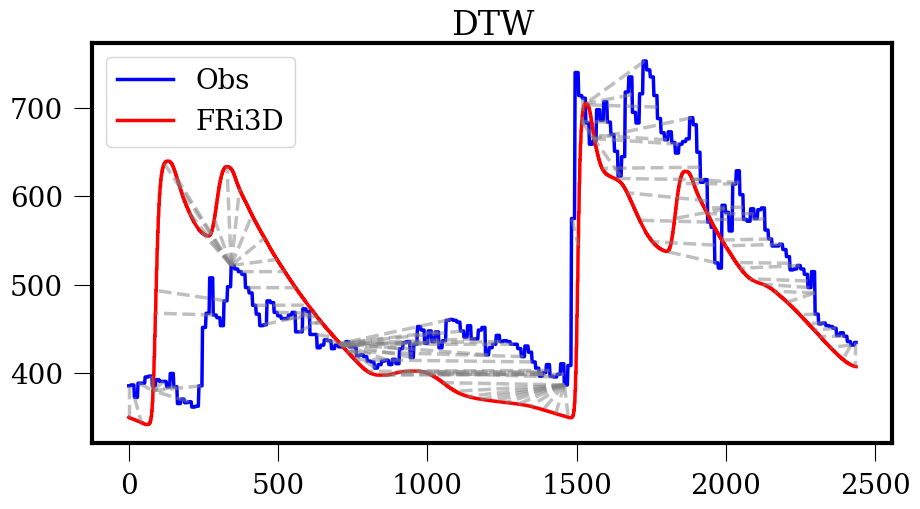

In [389]:
filtered_dates = np.array(datetime_list)[mask_dtw]
plot_alignment( moving_average_speed_Obs[mask_dtw][5000:], moving_average_speed_2[mask_dtw][5000:], alignment_path)